# Etude de cas de la Corée du Sud

Nous allons élaborer des modeles de prédiction linéaires et non-linéaires pour la Corée du Sud afin de proposer des prédictions dont on comparera les performances de maniere quantitatives. Nous allons proposer, pour le meilleur modele obtenu, des prévisions à l’échelle des mois à venir.

In [1]:
!pip install statsmodels

In [2]:
!pip install sklearn

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA

from sklearn.metrics import mean_squared_error
from math import sqrt

On importe les fichier csv contenant les données de PIB de la Corée du Sud de 1960 à aujourd'hui.

(Source : https://data.oecd.org/fr/gdp/pib-trimestriel.htm)

In [4]:
df = pd.read_csv('pib_coree.csv')
df

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,KOR,QGDP,TOT,PC_CHGPP,Q,1960-Q2,4.496005,NaN
1,KOR,QGDP,TOT,PC_CHGPP,Q,1960-Q3,-1.111563,NaN
2,KOR,QGDP,TOT,PC_CHGPP,Q,1960-Q4,0.596299,NaN
3,KOR,QGDP,TOT,PC_CHGPP,Q,1961-Q1,3.200927,NaN
4,KOR,QGDP,TOT,PC_CHGPP,Q,1961-Q2,4.316423,NaN
...,...,...,...,...,...,...,...,...
471,OECD,QGDP,TOT,PC_CHGPP,Q,2019-Q3,0.427321,NaN
472,OECD,QGDP,TOT,PC_CHGPP,Q,2019-Q4,0.190146,NaN
473,OECD,QGDP,TOT,PC_CHGPP,Q,2020-Q1,-1.855180,NaN
474,OECD,QGDP,TOT,PC_CHGPP,Q,2020-Q2,-10.559907,NaN


On conserve seulement les colonnes qui nous intéressent : le pays, la date et la variation en % du PIB.

In [5]:
df=df[['LOCATION','TIME','Value']].copy()
df

,LOCATION,TIME,Value
0,KOR,1960-Q2,4.496005
1,KOR,1960-Q3,-1.111563
2,KOR,1960-Q4,0.596299
3,KOR,1961-Q1,3.200927
4,KOR,1961-Q2,4.316423
...,...,...,...
471,OECD,2019-Q3,0.427321
472,OECD,2019-Q4,0.190146
473,OECD,2020-Q1,-1.855180
474,OECD,2020-Q2,-10.559907


On garde les données qui concernent seulement la Corée du Sud.

In [6]:
kor=df.loc[df['LOCATION']=='KOR',:]
kor

,LOCATION,TIME,Value
0,KOR,1960-Q2,4.496005
1,KOR,1960-Q3,-1.111563
2,KOR,1960-Q4,0.596299
3,KOR,1961-Q1,3.200927
4,KOR,1961-Q2,4.316423
...,...,...,...
237,KOR,2019-Q3,0.375455
238,KOR,2019-Q4,1.311630
239,KOR,2020-Q1,-1.281702
240,KOR,2020-Q2,-3.153852


On calcule les moyennes mobiles à partir des données de la colonne 'Value'.

La moyenne mobile, ou moyenne glissante, est un type de moyenne statistique utilisée pour analyser des séries ordonnées de données. En supprimant les fluctuations transitoires elle nous permet de souligner les tendances à plus long terme.

La moyenne mobile est calculée tour à tour sur chaque sous-ensemble de 3 valeurs consécutives.

In [7]:
mm=kor.rolling(3,min_periods=2).mean()
mm

,Value
0,NaN
1,1.692221
2,1.326914
3,0.895221
4,2.704550
...,...
237,0.349968
238,0.900409
239,0.135128
240,-1.041308


On ajoute dans notre dataset une colonne avec les moyennes mobiles.

In [8]:
kor['MM']=mm

C:\Users\anais\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
kor

,LOCATION,TIME,Value,MM
0,KOR,1960-Q2,4.496005,NaN
1,KOR,1960-Q3,-1.111563,1.692221
2,KOR,1960-Q4,0.596299,1.326914
3,KOR,1961-Q1,3.200927,0.895221
4,KOR,1961-Q2,4.316423,2.704550
...,...,...,...,...
237,KOR,2019-Q3,0.375455,0.349968
238,KOR,2019-Q4,1.311630,0.900409
239,KOR,2020-Q1,-1.281702,0.135128
240,KOR,2020-Q2,-3.153852,-1.041308


## Moyenne, variance et écart-type des valeurs de 'Value'

Calcul de la moyenne :

In [10]:
moy_kor=kor['Value'].mean()
moy_kor

1.757690686107438

Calcul de la variance :

In [11]:
var_kor=kor['Value'].var()
var_kor

4.008491061567266

Calcul de l'écart-type :

In [12]:
std_kor=kor['Value'].std()
std_kor

2.0021216400526884

## Graphiques évolution de la variation du PIB

Le graphique ci-dessous représente l'évolution de la variation en % du PIB de la Corée du Sud de 1960 à 2020.

On peut observer à partir du graphique qu'en 1997 il y a un pic. Il correspond à une crise politique et sociale qui a eue lieu en Corée du Sud suite à l'adoption d’une série de mesures de régression sociale.
Il y a eu de nombreuses grèves dans le secteur industriel, ce qui explique la chute du PIB à cette en période.

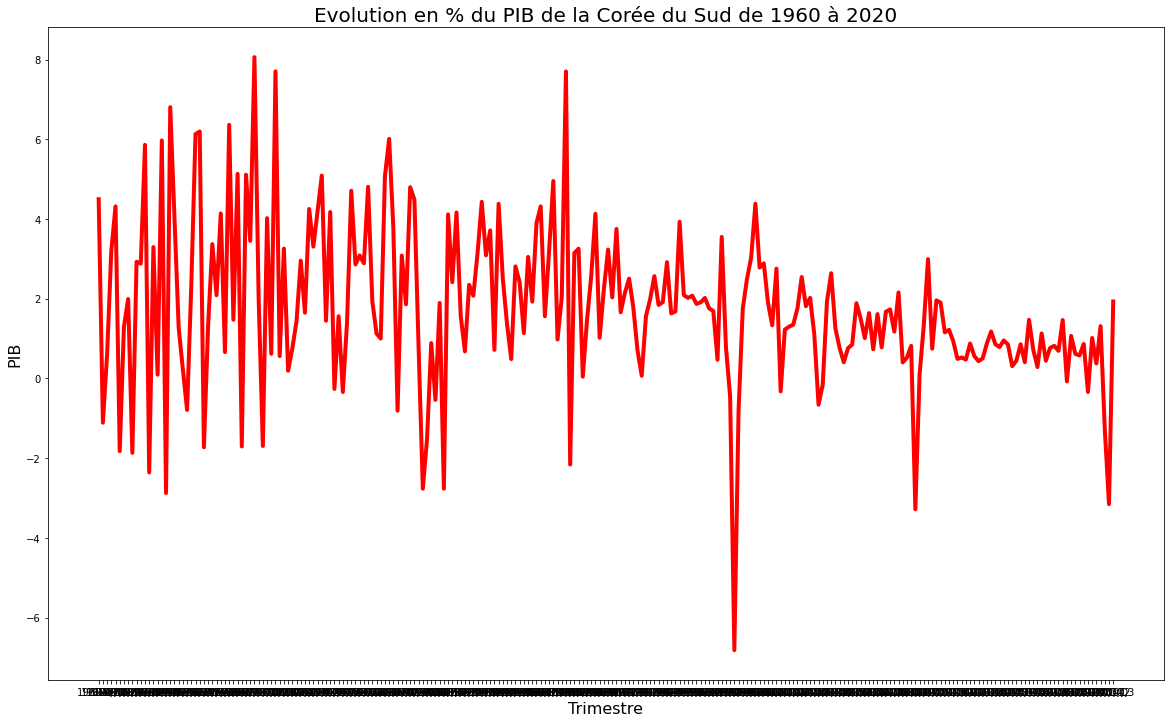

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,12))

plt.plot(kor['TIME'], kor['Value'], color='red', linewidth=4, markersize=10)


plt.xlabel('Trimestre', fontsize=16)
plt.ylabel('PIB', fontsize=16)


plt.title('Evolution en % du PIB de la Corée du Sud de 1960 à 2020', fontsize=20)
plt.show()

Le graphique ci-dessous représente la superposition de la moyenne mobile et de l'évolution du PIB.

Nous rappelons que le but d’un lissage par moyenne mobile est de faire apparaître l’allure de la tendance.

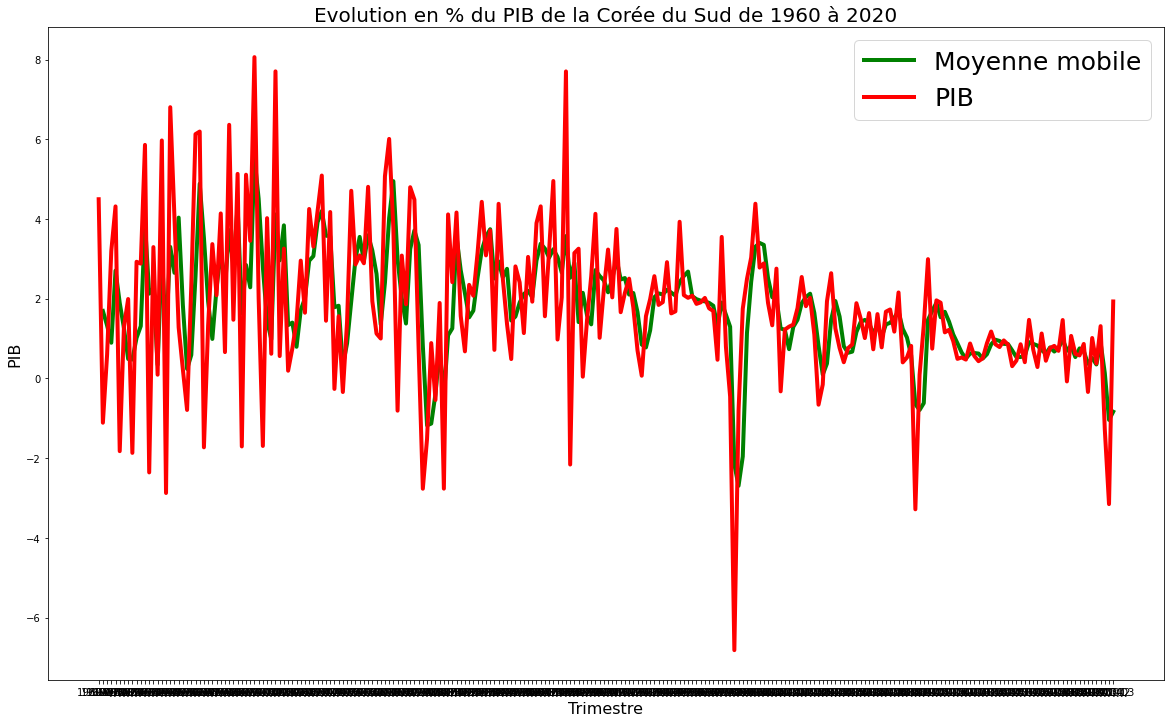

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,12))
plt.plot(kor['TIME'], kor['MM'], color='green',label='Moyenne mobile', linewidth=4, markersize=10)
plt.plot(kor['TIME'], kor['Value'], color='red',label='PIB', linewidth=4, markersize=10)


plt.xlabel('Trimestre', fontsize=16)
plt.ylabel('PIB', fontsize=16)
plt.legend(prop={"size":25})

plt.title('Evolution en % du PIB de la Corée du Sud de 1960 à 2020', fontsize=20)
plt.show()

# Modèle prédictif non linéaire

Nous avons réalisé un modèle de prédiction non linéaire de l'évolution de la variation du PIB pour cela nous avons utilisé le modèle ARIMA.

ARIMA pour AutoregRessive Integrated MovingAverage, est un modèle adapté aux séries temporelles, il permet de mieux comprendre et de prédire les valeurs futures de la série.

Pour effectuer ce modèle nous avons conservé dans un dataset seulement les moyennes mobiles et les dates.

In [15]:
korAC=kor[['TIME','MM']]
korAC=korAC.dropna()
korAC

,TIME,MM
1,1960-Q3,1.692221
2,1960-Q4,1.326914
3,1961-Q1,0.895221
4,1961-Q2,2.704550
5,1961-Q3,1.897368
...,...,...
237,2019-Q3,0.349968
238,2019-Q4,0.900409
239,2020-Q1,0.135128
240,2020-Q2,-1.041308


Le graphe ci-dessous correspond au graphique d'autocorrélation des valeurs des moyennes mobiles.

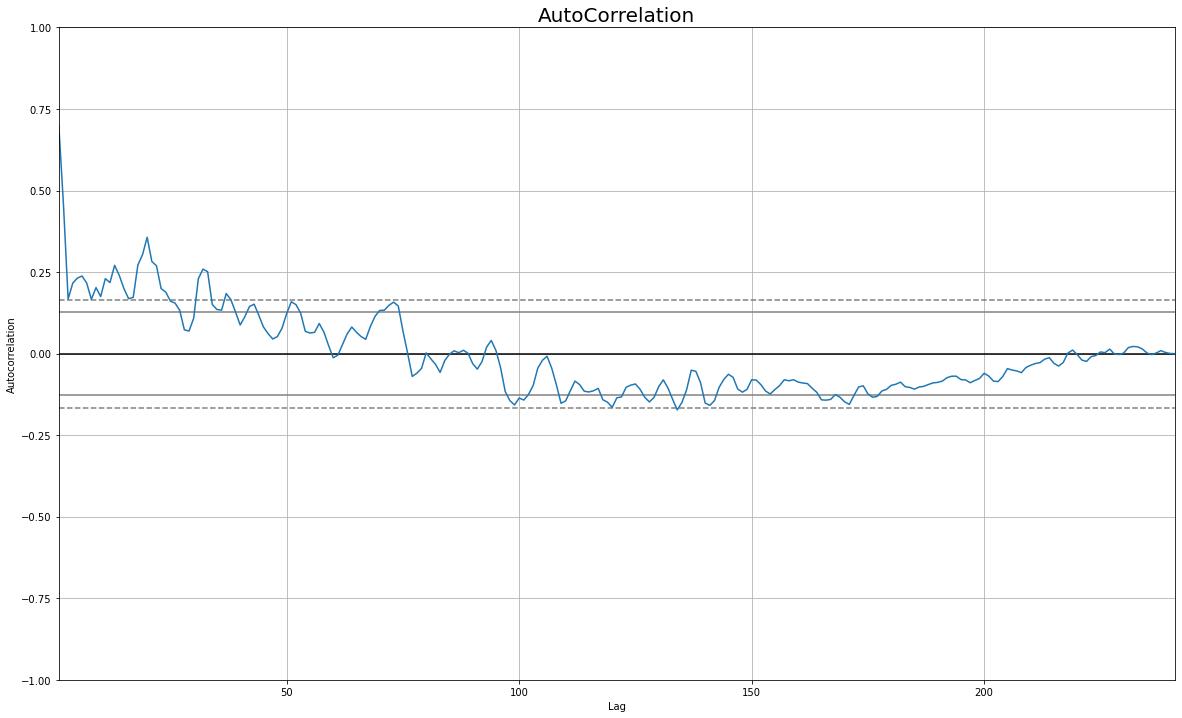

In [16]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(20,12))
autocorrelation_plot(korAC['MM'])
plt.title('AutoCorrelation',fontsize=20)
plt.show()

On transforme les données de la colonne 'TIME' du format YYYY-QQ à YYYY-MM-DD.

In [17]:
korAC['TIME']=[pd.to_datetime(x[:5]) + pd.offsets.QuarterBegin(int(x[6:])) for x in korAC['TIME']]
korAC

,TIME,MM
1,1960-09-01,1.692221
2,1960-12-01,1.326914
3,1961-03-01,0.895221
4,1961-06-01,2.704550
5,1961-09-01,1.897368
...,...,...
237,2019-09-01,0.349968
238,2019-12-01,0.900409
239,2020-03-01,0.135128
240,2020-06-01,-1.041308


In [18]:
korAC.dtypes

TIME    datetime64[ns]
MM             float64
dtype: object

On seléctionne les paramètres pour le modèle de série temporelle ARIMA.

Notre premier objectif est de trouver les valeurs ARIMA(p,d,q)(P,D,Q)s, ces paramètres vont nous permettre d'optimiser le modèle.

Les différents paramètres sont :
   - p: qui correspond à la partie auto régressive, ce paramètre permet d'incorporer les valeurs du passé dans notre modèle.
   - d: qui correspond au nombre de fois que les observations sont différenciées, c'est le degré de différenciation.
   - q: qui correspond à la taille de la fenêtre de la moyenne mobile de notre modèle. 

(p,d,q) sont des paramètres non saisonniers alors que (P,D,Q) suivent la même définition mais sont appliqués à la partie saisonnière de la série temporelle.

s correspond à la périodicité de la série, ici 4 puisque c'est en quartile.

In [19]:
import itertools


# Define the p and q parameters to take any value between 0 and 4
p = d =q = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]


On modifie le dataset, en plaçant les données de la colonne 'TIME' en index.

In [20]:
korNL=korAC.copy()
korNL.set_index('TIME',inplace=True)
print(korNL)

                  MM
TIME                
1960-09-01  1.692221
1960-12-01  1.326914
1961-03-01  0.895221
1961-06-01  2.704550
1961-09-01  1.897368
...              ...
2019-09-01  0.349968
2019-12-01  0.900409
2020-03-01  0.135128
2020-06-01 -1.041308
2020-09-01 -0.834905

[241 rows x 1 columns]


Nous utilisons une «recherche de grille» pour explorer de manière itérative différentes combinaisons de paramètres. Pour chaque combinaison de paramètres, nous ajustons un nouveau modèle ARIMA saisonnier avec la fonction SARIMAX() et évaluons sa qualité globale en affichant le AIC.  

Commençons par générer les différentes combinaisons de paramètres que nous souhaitons évaluer:

In [21]:
#Cette partie prend du temps à s'éxecuter c'est pourquoi nous l'avons mis en commentaire
#Ce code nous affiche les différents possibilités de paramètres d'ARIMA avec la valeur du coefficient AIC 
'''import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:

            mod = sm.tsa.statespace.SARIMAX(korNL,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}4 - AIC:{}'.format(param, param_seasonal, results.aic))'''


ARIMA(0, 0, 0)x(0, 0, 0, 4)4 - AIC:1054.0046461060315
ARIMA(0, 0, 0)x(0, 0, 1, 4)4 - AIC:940.4482431830909
ARIMA(0, 0, 0)x(0, 0, 2, 4)4 - AIC:891.329319802111
ARIMA(0, 0, 0)x(0, 0, 3, 4)4 - AIC:853.9791716434937
ARIMA(0, 0, 0)x(0, 1, 0, 4)4 - AIC:883.4249903461132
ARIMA(0, 0, 0)x(0, 1, 1, 4)4 - AIC:739.6478532138168
ARIMA(0, 0, 0)x(0, 1, 2, 4)4 - AIC:725.4200272871342
ARIMA(0, 0, 0)x(0, 1, 3, 4)4 - AIC:708.0534547825948
ARIMA(0, 0, 0)x(0, 2, 0, 4)4 - AIC:1120.9478622074976
ARIMA(0, 0, 0)x(0, 2, 1, 4)4 - AIC:869.6044875108744
ARIMA(0, 0, 0)x(0, 2, 2, 4)4 - AIC:727.4322069910804
ARIMA(0, 0, 0)x(0, 2, 3, 4)4 - AIC:713.3943397633259
ARIMA(0, 0, 0)x(0, 3, 0, 4)4 - AIC:1268.9199444271867
ARIMA(0, 0, 0)x(0, 3, 1, 4)4 - AIC:1006.6174162731968
ARIMA(0, 0, 0)x(0, 3, 2, 4)4 - AIC:846.7163413066248
ARIMA(0, 0, 0)x(0, 3, 3, 4)4 - AIC:831.9637195765324
ARIMA(0, 0, 0)x(1, 0, 0, 4)4 - AIC:854.3383041832967
ARIMA(0, 0, 0)x(1, 0, 1, 4)4 - AIC:746.7794583760941
ARIMA(0, 0, 0)x(1, 0, 2, 4)4 - AIC:735.5889

ARIMA(0, 0, 2)x(1, 2, 3, 4)4 - AIC:457.7495584802639
ARIMA(0, 0, 2)x(1, 3, 0, 4)4 - AIC:767.0619758818161
ARIMA(0, 0, 2)x(1, 3, 1, 4)4 - AIC:651.7872403199185
ARIMA(0, 0, 2)x(1, 3, 2, 4)4 - AIC:633.9033478657793
ARIMA(0, 0, 2)x(1, 3, 3, 4)4 - AIC:568.0444961017589
ARIMA(0, 0, 2)x(2, 0, 0, 4)4 - AIC:536.8883960374377
ARIMA(0, 0, 2)x(2, 0, 1, 4)4 - AIC:479.76938173814915
ARIMA(0, 0, 2)x(2, 0, 2, 4)4 - AIC:468.88374257366826
ARIMA(0, 0, 2)x(2, 0, 3, 4)4 - AIC:450.3588295009903
ARIMA(0, 0, 2)x(2, 1, 0, 4)4 - AIC:529.7446065387489
ARIMA(0, 0, 2)x(2, 1, 1, 4)4 - AIC:471.7413056118343
ARIMA(0, 0, 2)x(2, 1, 2, 4)4 - AIC:462.6006231043908
ARIMA(0, 0, 2)x(2, 1, 3, 4)4 - AIC:439.2551118319275
ARIMA(0, 0, 2)x(2, 2, 0, 4)4 - AIC:662.5019174258109
ARIMA(0, 0, 2)x(2, 2, 1, 4)4 - AIC:540.7348936367023
ARIMA(0, 0, 2)x(2, 2, 2, 4)4 - AIC:479.06776906542626
ARIMA(0, 0, 2)x(2, 2, 3, 4)4 - AIC:459.7224498282451
ARIMA(0, 0, 2)x(2, 3, 0, 4)4 - AIC:740.8079799613886
ARIMA(0, 0, 2)x(2, 3, 1, 4)4 - AIC:649.2582

ARIMA(0, 1, 0)x(3, 1, 2, 4)4 - AIC:620.8708396785752
ARIMA(0, 1, 0)x(3, 1, 3, 4)4 - AIC:617.3023956501734
ARIMA(0, 1, 0)x(3, 2, 0, 4)4 - AIC:803.0060784291516
ARIMA(0, 1, 0)x(3, 2, 1, 4)4 - AIC:685.0827061521021
ARIMA(0, 1, 0)x(3, 2, 2, 4)4 - AIC:656.5546018106493
ARIMA(0, 1, 0)x(3, 2, 3, 4)4 - AIC:657.5782668156635
ARIMA(0, 1, 0)x(3, 3, 0, 4)4 - AIC:891.0949538030943
ARIMA(0, 1, 0)x(3, 3, 1, 4)4 - AIC:789.3491370560617
ARIMA(0, 1, 0)x(3, 3, 2, 4)4 - AIC:710.3673123220697
ARIMA(0, 1, 0)x(3, 3, 3, 4)4 - AIC:687.928462933095
ARIMA(0, 1, 1)x(0, 0, 0, 4)4 - AIC:661.115854215161
ARIMA(0, 1, 1)x(0, 0, 1, 4)4 - AIC:650.969248071895
ARIMA(0, 1, 1)x(0, 0, 2, 4)4 - AIC:633.7911223176619
ARIMA(0, 1, 1)x(0, 0, 3, 4)4 - AIC:609.5980070382694
ARIMA(0, 1, 1)x(0, 1, 0, 4)4 - AIC:795.3953926700291
ARIMA(0, 1, 1)x(0, 1, 1, 4)4 - AIC:648.7960048851593
ARIMA(0, 1, 1)x(0, 1, 2, 4)4 - AIC:636.631833681809
ARIMA(0, 1, 1)x(0, 1, 3, 4)4 - AIC:634.2582387741389
ARIMA(0, 1, 1)x(0, 2, 0, 4)4 - AIC:996.42455200977

ARIMA(0, 1, 3)x(1, 0, 1, 4)4 - AIC:467.57738673006554
ARIMA(0, 1, 3)x(1, 0, 2, 4)4 - AIC:445.1158889708952
ARIMA(0, 1, 3)x(1, 0, 3, 4)4 - AIC:426.548445967638
ARIMA(0, 1, 3)x(1, 1, 0, 4)4 - AIC:573.5100230816279
ARIMA(0, 1, 3)x(1, 1, 1, 4)4 - AIC:469.1842141238384
ARIMA(0, 1, 3)x(1, 1, 2, 4)4 - AIC:459.2499079368257
ARIMA(0, 1, 3)x(1, 1, 3, 4)4 - AIC:435.5059360594316
ARIMA(0, 1, 3)x(1, 2, 0, 4)4 - AIC:728.8778775996841
ARIMA(0, 1, 3)x(1, 2, 1, 4)4 - AIC:573.9050884371975
ARIMA(0, 1, 3)x(1, 2, 2, 4)4 - AIC:469.77072308695307
ARIMA(0, 1, 3)x(1, 2, 3, 4)4 - AIC:449.2627684077735
ARIMA(0, 1, 3)x(1, 3, 0, 4)4 - AIC:770.5715671362238
ARIMA(0, 1, 3)x(1, 3, 1, 4)4 - AIC:652.9741211088392
ARIMA(0, 1, 3)x(1, 3, 2, 4)4 - AIC:593.8507286872523
ARIMA(0, 1, 3)x(1, 3, 3, 4)4 - AIC:573.1982261880731
ARIMA(0, 1, 3)x(2, 0, 0, 4)4 - AIC:464.6988706780983
ARIMA(0, 1, 3)x(2, 0, 1, 4)4 - AIC:466.6984333149254
ARIMA(0, 1, 3)x(2, 0, 2, 4)4 - AIC:442.7813631932661
ARIMA(0, 1, 3)x(2, 0, 3, 4)4 - AIC:427.833506

ARIMA(0, 2, 1)x(2, 3, 0, 4)4 - AIC:925.7361000002228
ARIMA(0, 2, 1)x(2, 3, 1, 4)4 - AIC:836.1607423266835
ARIMA(0, 2, 1)x(2, 3, 2, 4)4 - AIC:779.6748919707909
ARIMA(0, 2, 1)x(2, 3, 3, 4)4 - AIC:810.9291106167227
ARIMA(0, 2, 1)x(3, 0, 0, 4)4 - AIC:631.8625571591199
ARIMA(0, 2, 1)x(3, 0, 1, 4)4 - AIC:616.2269634814625
ARIMA(0, 2, 1)x(3, 0, 2, 4)4 - AIC:616.5882700655063
ARIMA(0, 2, 1)x(3, 0, 3, 4)4 - AIC:604.2983361853462
ARIMA(0, 2, 1)x(3, 1, 0, 4)4 - AIC:680.8975725775622
ARIMA(0, 2, 1)x(3, 1, 1, 4)4 - AIC:642.8940609244474
ARIMA(0, 2, 1)x(3, 1, 2, 4)4 - AIC:635.9937243026862
ARIMA(0, 2, 1)x(3, 1, 3, 4)4 - AIC:613.13782485328
ARIMA(0, 2, 1)x(3, 2, 0, 4)4 - AIC:807.7732191485774
ARIMA(0, 2, 1)x(3, 2, 1, 4)4 - AIC:696.0617522290645
ARIMA(0, 2, 1)x(3, 2, 2, 4)4 - AIC:670.0463871445487
ARIMA(0, 2, 1)x(3, 2, 3, 4)4 - AIC:663.5603329328463
ARIMA(0, 2, 1)x(3, 3, 0, 4)4 - AIC:895.984608263557
ARIMA(0, 2, 1)x(3, 3, 1, 4)4 - AIC:800.4125036254281
ARIMA(0, 2, 1)x(3, 3, 2, 4)4 - AIC:879.6560450721

ARIMA(0, 3, 0)x(0, 1, 3, 4)4 - AIC:984.4527724967115
ARIMA(0, 3, 0)x(0, 2, 0, 4)4 - AIC:1281.1364450733095
ARIMA(0, 3, 0)x(0, 2, 1, 4)4 - AIC:1129.7050500559803
ARIMA(0, 3, 0)x(0, 2, 2, 4)4 - AIC:1104.5281009337857
ARIMA(0, 3, 0)x(0, 2, 3, 4)4 - AIC:966.228361489425
ARIMA(0, 3, 0)x(0, 3, 0, 4)4 - AIC:1348.7836124890605
ARIMA(0, 3, 0)x(0, 3, 1, 4)4 - AIC:1188.5989862807724
ARIMA(0, 3, 0)x(0, 3, 2, 4)4 - AIC:1159.2788250342267
ARIMA(0, 3, 0)x(0, 3, 3, 4)4 - AIC:1069.3562352890235
ARIMA(0, 3, 0)x(1, 0, 0, 4)4 - AIC:1067.3532584877757
ARIMA(0, 3, 0)x(1, 0, 1, 4)4 - AIC:1029.095896326921
ARIMA(0, 3, 0)x(1, 0, 2, 4)4 - AIC:984.487425511499
ARIMA(0, 3, 0)x(1, 0, 3, 4)4 - AIC:949.194266135818
ARIMA(0, 3, 0)x(1, 1, 0, 4)4 - AIC:1133.5740307689748
ARIMA(0, 3, 0)x(1, 1, 1, 4)4 - AIC:1119.5595313819447
ARIMA(0, 3, 0)x(1, 1, 2, 4)4 - AIC:989.2518534449152
ARIMA(0, 3, 0)x(1, 1, 3, 4)4 - AIC:975.4567706509854
ARIMA(0, 3, 0)x(1, 2, 0, 4)4 - AIC:1252.4445443089294
ARIMA(0, 3, 0)x(1, 2, 1, 4)4 - AIC:113

ARIMA(0, 3, 2)x(2, 0, 2, 4)4 - AIC:646.3751924427266
ARIMA(0, 3, 2)x(2, 0, 3, 4)4 - AIC:612.2112120262917
ARIMA(0, 3, 2)x(2, 1, 0, 4)4 - AIC:728.8224655909653
ARIMA(0, 3, 2)x(2, 1, 1, 4)4 - AIC:672.575101793434
ARIMA(0, 3, 2)x(2, 1, 2, 4)4 - AIC:641.1395762279384
ARIMA(0, 3, 2)x(2, 1, 3, 4)4 - AIC:608.5538954342949
ARIMA(0, 3, 2)x(2, 2, 0, 4)4 - AIC:858.1831753727415
ARIMA(0, 3, 2)x(2, 2, 1, 4)4 - AIC:744.3016577433309
ARIMA(0, 3, 2)x(2, 2, 2, 4)4 - AIC:680.8037350534075
ARIMA(0, 3, 2)x(2, 2, 3, 4)4 - AIC:635.9924922762007
ARIMA(0, 3, 2)x(2, 3, 0, 4)4 - AIC:936.6932957493881
ARIMA(0, 3, 2)x(2, 3, 1, 4)4 - AIC:848.5654167639058
ARIMA(0, 3, 2)x(2, 3, 2, 4)4 - AIC:818.9752491148255
ARIMA(0, 3, 2)x(2, 3, 3, 4)4 - AIC:898.2453129036847
ARIMA(0, 3, 2)x(3, 0, 0, 4)4 - AIC:630.3596002128027
ARIMA(0, 3, 2)x(3, 0, 1, 4)4 - AIC:634.152013312402
ARIMA(0, 3, 2)x(3, 0, 2, 4)4 - AIC:635.5416937854783
ARIMA(0, 3, 2)x(3, 0, 3, 4)4 - AIC:607.1326168886792
ARIMA(0, 3, 2)x(3, 1, 0, 4)4 - AIC:692.355069505

ARIMA(1, 0, 0)x(3, 3, 1, 4)4 - AIC:749.5534073109856
ARIMA(1, 0, 0)x(3, 3, 2, 4)4 - AIC:672.783609751438
ARIMA(1, 0, 0)x(3, 3, 3, 4)4 - AIC:757.7874592265138
ARIMA(1, 0, 1)x(0, 0, 0, 4)4 - AIC:654.5651671863161
ARIMA(1, 0, 1)x(0, 0, 1, 4)4 - AIC:642.8275504991276
ARIMA(1, 0, 1)x(0, 0, 2, 4)4 - AIC:634.8765169303748
ARIMA(1, 0, 1)x(0, 0, 3, 4)4 - AIC:615.5990012666404
ARIMA(1, 0, 1)x(0, 1, 0, 4)4 - AIC:740.4487007184929
ARIMA(1, 0, 1)x(0, 1, 1, 4)4 - AIC:621.5121059683855
ARIMA(1, 0, 1)x(0, 1, 2, 4)4 - AIC:601.9259606707429
ARIMA(1, 0, 1)x(0, 1, 3, 4)4 - AIC:594.6074489993796
ARIMA(1, 0, 1)x(0, 2, 0, 4)4 - AIC:944.4694585281084
ARIMA(1, 0, 1)x(0, 2, 1, 4)4 - AIC:731.6771618251038
ARIMA(1, 0, 1)x(0, 2, 2, 4)4 - AIC:621.5915907326289
ARIMA(1, 0, 1)x(0, 2, 3, 4)4 - AIC:597.7632964554887
ARIMA(1, 0, 1)x(0, 3, 0, 4)4 - AIC:1064.2116960882895
ARIMA(1, 0, 1)x(0, 3, 1, 4)4 - AIC:848.3212451691282
ARIMA(1, 0, 1)x(0, 3, 2, 4)4 - AIC:722.5906396745012
ARIMA(1, 0, 1)x(0, 3, 3, 4)4 - AIC:713.8116903

ARIMA(1, 0, 3)x(1, 2, 0, 4)4 - AIC:698.8094040524242
ARIMA(1, 0, 3)x(1, 2, 1, 4)4 - AIC:556.7092602180794
ARIMA(1, 0, 3)x(1, 2, 2, 4)4 - AIC:475.60654491285186
ARIMA(1, 0, 3)x(1, 2, 3, 4)4 - AIC:445.2804379419891
ARIMA(1, 0, 3)x(1, 3, 0, 4)4 - AIC:745.633952758956
ARIMA(1, 0, 3)x(1, 3, 1, 4)4 - AIC:644.580532993069
ARIMA(1, 0, 3)x(1, 3, 2, 4)4 - AIC:626.9625063789952
ARIMA(1, 0, 3)x(1, 3, 3, 4)4 - AIC:569.3043314018452
ARIMA(1, 0, 3)x(2, 0, 0, 4)4 - AIC:463.82495477140384
ARIMA(1, 0, 3)x(2, 0, 1, 4)4 - AIC:465.7987186679767
ARIMA(1, 0, 3)x(2, 0, 2, 4)4 - AIC:442.7803775919074
ARIMA(1, 0, 3)x(2, 0, 3, 4)4 - AIC:433.33721877160497
ARIMA(1, 0, 3)x(2, 1, 0, 4)4 - AIC:522.5578834881098
ARIMA(1, 0, 3)x(2, 1, 1, 4)4 - AIC:470.86128661156397
ARIMA(1, 0, 3)x(2, 1, 2, 4)4 - AIC:463.6891571539574
ARIMA(1, 0, 3)x(2, 1, 3, 4)4 - AIC:446.1559540238966
ARIMA(1, 0, 3)x(2, 2, 0, 4)4 - AIC:639.885746510337
ARIMA(1, 0, 3)x(2, 2, 1, 4)4 - AIC:532.9552763261362
ARIMA(1, 0, 3)x(2, 2, 2, 4)4 - AIC:478.883683

ARIMA(1, 1, 1)x(3, 0, 3, 4)4 - AIC:593.2175084306174
ARIMA(1, 1, 1)x(3, 1, 0, 4)4 - AIC:675.8360742231598
ARIMA(1, 1, 1)x(3, 1, 1, 4)4 - AIC:599.7435633970468
ARIMA(1, 1, 1)x(3, 1, 2, 4)4 - AIC:588.861425868842
ARIMA(1, 1, 1)x(3, 1, 3, 4)4 - AIC:588.8397340173237
ARIMA(1, 1, 1)x(3, 2, 0, 4)4 - AIC:762.5523436993896
ARIMA(1, 1, 1)x(3, 2, 1, 4)4 - AIC:653.2688426751904
ARIMA(1, 1, 1)x(3, 2, 2, 4)4 - AIC:627.1817193193633
ARIMA(1, 1, 1)x(3, 2, 3, 4)4 - AIC:623.9435478726584
ARIMA(1, 1, 1)x(3, 3, 0, 4)4 - AIC:852.8857685714514
ARIMA(1, 1, 1)x(3, 3, 1, 4)4 - AIC:760.8150574468207
ARIMA(1, 1, 1)x(3, 3, 2, 4)4 - AIC:688.4032662722599
ARIMA(1, 1, 1)x(3, 3, 3, 4)4 - AIC:762.7847277542984
ARIMA(1, 1, 2)x(0, 0, 0, 4)4 - AIC:550.9606087867684
ARIMA(1, 1, 2)x(0, 0, 1, 4)4 - AIC:538.2509267547013
ARIMA(1, 1, 2)x(0, 0, 2, 4)4 - AIC:526.2583545867118
ARIMA(1, 1, 2)x(0, 0, 3, 4)4 - AIC:506.415618804033
ARIMA(1, 1, 2)x(0, 1, 0, 4)4 - AIC:681.8479264625032
ARIMA(1, 1, 2)x(0, 1, 1, 4)4 - AIC:609.440641815

ARIMA(1, 2, 0)x(0, 3, 2, 4)4 - AIC:849.4483738316827
ARIMA(1, 2, 0)x(0, 3, 3, 4)4 - AIC:829.7606462834432
ARIMA(1, 2, 0)x(1, 0, 0, 4)4 - AIC:736.6845960891551
ARIMA(1, 2, 0)x(1, 0, 1, 4)4 - AIC:737.9109940135546
ARIMA(1, 2, 0)x(1, 0, 2, 4)4 - AIC:713.8078462014857
ARIMA(1, 2, 0)x(1, 0, 3, 4)4 - AIC:688.1543245333463
ARIMA(1, 2, 0)x(1, 1, 0, 4)4 - AIC:831.10586071143
ARIMA(1, 2, 0)x(1, 1, 1, 4)4 - AIC:741.3051026022631
ARIMA(1, 2, 0)x(1, 1, 2, 4)4 - AIC:718.288629509525
ARIMA(1, 2, 0)x(1, 1, 3, 4)4 - AIC:712.2003980053883
ARIMA(1, 2, 0)x(1, 2, 0, 4)4 - AIC:983.1985184310852
ARIMA(1, 2, 0)x(1, 2, 1, 4)4 - AIC:839.5432100503651
ARIMA(1, 2, 0)x(1, 2, 2, 4)4 - AIC:742.5835882219328
ARIMA(1, 2, 0)x(1, 2, 3, 4)4 - AIC:722.5371493849034
ARIMA(1, 2, 0)x(1, 3, 0, 4)4 - AIC:1023.778330440239
ARIMA(1, 2, 0)x(1, 3, 1, 4)4 - AIC:931.1862763421584
ARIMA(1, 2, 0)x(1, 3, 2, 4)4 - AIC:851.0873820845537
ARIMA(1, 2, 0)x(1, 3, 3, 4)4 - AIC:828.6390813239301
ARIMA(1, 2, 0)x(2, 0, 0, 4)4 - AIC:720.6223705462

ARIMA(1, 2, 2)x(2, 2, 1, 4)4 - AIC:720.2919497583207
ARIMA(1, 2, 2)x(2, 2, 2, 4)4 - AIC:666.692708284236
ARIMA(1, 2, 2)x(2, 2, 3, 4)4 - AIC:645.3612992183082
ARIMA(1, 2, 2)x(2, 3, 0, 4)4 - AIC:917.0690385411508
ARIMA(1, 2, 2)x(2, 3, 1, 4)4 - AIC:825.5021233510502
ARIMA(1, 2, 2)x(2, 3, 2, 4)4 - AIC:776.4695394081532
ARIMA(1, 2, 2)x(2, 3, 3, 4)4 - AIC:748.3888267919345
ARIMA(1, 2, 2)x(3, 0, 0, 4)4 - AIC:601.7641095453318
ARIMA(1, 2, 2)x(3, 0, 1, 4)4 - AIC:601.5602550639638
ARIMA(1, 2, 2)x(3, 0, 2, 4)4 - AIC:602.5309558284035
ARIMA(1, 2, 2)x(3, 0, 3, 4)4 - AIC:584.446369847321
ARIMA(1, 2, 2)x(3, 1, 0, 4)4 - AIC:679.8592899628336
ARIMA(1, 2, 2)x(3, 1, 1, 4)4 - AIC:617.7271002894404
ARIMA(1, 2, 2)x(3, 1, 2, 4)4 - AIC:619.6074987936047
ARIMA(1, 2, 2)x(3, 1, 3, 4)4 - AIC:609.4528790002037
ARIMA(1, 2, 2)x(3, 2, 0, 4)4 - AIC:800.5627145011831
ARIMA(1, 2, 2)x(3, 2, 1, 4)4 - AIC:695.4461375539187
ARIMA(1, 2, 2)x(3, 2, 2, 4)4 - AIC:650.907638320626
ARIMA(1, 2, 2)x(3, 2, 3, 4)4 - AIC:638.3586778792

ARIMA(1, 3, 1)x(0, 1, 1, 4)4 - AIC:738.5221805065082
ARIMA(1, 3, 1)x(0, 1, 2, 4)4 - AIC:724.1017315502394
ARIMA(1, 3, 1)x(0, 1, 3, 4)4 - AIC:717.1874516542712
ARIMA(1, 3, 1)x(0, 2, 0, 4)4 - AIC:1071.8373108733463
ARIMA(1, 3, 1)x(0, 2, 1, 4)4 - AIC:864.7724550164381
ARIMA(1, 3, 1)x(0, 2, 2, 4)4 - AIC:845.589441078975
ARIMA(1, 3, 1)x(0, 2, 3, 4)4 - AIC:719.7048848106915
ARIMA(1, 3, 1)x(0, 3, 0, 4)4 - AIC:1181.433508956031
ARIMA(1, 3, 1)x(0, 3, 1, 4)4 - AIC:971.9216061980718
ARIMA(1, 3, 1)x(0, 3, 2, 4)4 - AIC:859.5586054280316
ARIMA(1, 3, 1)x(0, 3, 3, 4)4 - AIC:838.4456653203754
ARIMA(1, 3, 1)x(1, 0, 0, 4)4 - AIC:742.0024590148523
ARIMA(1, 3, 1)x(1, 0, 1, 4)4 - AIC:739.4220288050195
ARIMA(1, 3, 1)x(1, 0, 2, 4)4 - AIC:710.8006796712855
ARIMA(1, 3, 1)x(1, 0, 3, 4)4 - AIC:690.8298181155967
ARIMA(1, 3, 1)x(1, 1, 0, 4)4 - AIC:831.8793349185852
ARIMA(1, 3, 1)x(1, 1, 1, 4)4 - AIC:740.4677477619864
ARIMA(1, 3, 1)x(1, 1, 2, 4)4 - AIC:721.8422978952702
ARIMA(1, 3, 1)x(1, 1, 3, 4)4 - AIC:716.0723508

ARIMA(1, 3, 3)x(2, 0, 0, 4)4 - AIC:682.6701555285055
ARIMA(1, 3, 3)x(2, 0, 1, 4)4 - AIC:686.5894178237459
ARIMA(1, 3, 3)x(2, 0, 2, 4)4 - AIC:662.5961190146518
ARIMA(1, 3, 3)x(2, 0, 3, 4)4 - AIC:648.9332063053469
ARIMA(1, 3, 3)x(2, 1, 0, 4)4 - AIC:749.6919547277417
ARIMA(1, 3, 3)x(2, 1, 1, 4)4 - AIC:696.0247868725037
ARIMA(1, 3, 3)x(2, 1, 2, 4)4 - AIC:684.8223062428365
ARIMA(1, 3, 3)x(2, 1, 3, 4)4 - AIC:657.8665996336072
ARIMA(1, 3, 3)x(2, 2, 0, 4)4 - AIC:870.6879007711088
ARIMA(1, 3, 3)x(2, 2, 1, 4)4 - AIC:761.7836269409037
ARIMA(1, 3, 3)x(2, 2, 2, 4)4 - AIC:704.378769466419
ARIMA(1, 3, 3)x(2, 2, 3, 4)4 - AIC:666.551215942982
ARIMA(1, 3, 3)x(2, 3, 0, 4)4 - AIC:950.3450749227143
ARIMA(1, 3, 3)x(2, 3, 1, 4)4 - AIC:864.790121091067
ARIMA(1, 3, 3)x(2, 3, 2, 4)4 - AIC:843.9428582406413
ARIMA(1, 3, 3)x(2, 3, 3, 4)4 - AIC:824.6454454821179
ARIMA(1, 3, 3)x(3, 0, 0, 4)4 - AIC:659.770683047531
ARIMA(1, 3, 3)x(3, 0, 1, 4)4 - AIC:662.9932675874502
ARIMA(1, 3, 3)x(3, 0, 2, 4)4 - AIC:659.14304392899

ARIMA(2, 0, 1)x(3, 2, 3, 4)4 - AIC:569.8002227457345
ARIMA(2, 0, 1)x(3, 3, 0, 4)4 - AIC:785.9731693165393
ARIMA(2, 0, 1)x(3, 3, 1, 4)4 - AIC:681.8489993808278
ARIMA(2, 0, 1)x(3, 3, 2, 4)4 - AIC:619.4237186429244
ARIMA(2, 0, 1)x(3, 3, 3, 4)4 - AIC:623.2249778371348
ARIMA(2, 0, 2)x(0, 0, 0, 4)4 - AIC:532.1156071678931
ARIMA(2, 0, 2)x(0, 0, 1, 4)4 - AIC:514.7129229712804
ARIMA(2, 0, 2)x(0, 0, 2, 4)4 - AIC:508.6933534018663
ARIMA(2, 0, 2)x(0, 0, 3, 4)4 - AIC:492.1401349094233
ARIMA(2, 0, 2)x(0, 1, 0, 4)4 - AIC:585.0593643610016
ARIMA(2, 0, 2)x(0, 1, 1, 4)4 - AIC:473.85880516499117
ARIMA(2, 0, 2)x(0, 1, 2, 4)4 - AIC:468.10425721487775
ARIMA(2, 0, 2)x(0, 1, 3, 4)4 - AIC:454.4116172902519
ARIMA(2, 0, 2)x(0, 2, 0, 4)4 - AIC:703.5537548898208
ARIMA(2, 0, 2)x(0, 2, 1, 4)4 - AIC:585.8466517901966
ARIMA(2, 0, 2)x(0, 2, 2, 4)4 - AIC:480.76126299026953
ARIMA(2, 0, 2)x(0, 2, 3, 4)4 - AIC:465.8356132689672
ARIMA(2, 0, 2)x(0, 3, 0, 4)4 - AIC:812.2601997731595
ARIMA(2, 0, 2)x(0, 3, 1, 4)4 - AIC:690.0412

ARIMA(2, 1, 0)x(1, 1, 2, 4)4 - AIC:639.3053984701205
ARIMA(2, 1, 0)x(1, 1, 3, 4)4 - AIC:634.1778694292968
ARIMA(2, 1, 0)x(1, 2, 0, 4)4 - AIC:905.7727350648498
ARIMA(2, 1, 0)x(1, 2, 1, 4)4 - AIC:759.2242621681571
ARIMA(2, 1, 0)x(1, 2, 2, 4)4 - AIC:667.9757988501422
ARIMA(2, 1, 0)x(1, 2, 3, 4)4 - AIC:646.9321096241006
ARIMA(2, 1, 0)x(1, 3, 0, 4)4 - AIC:946.5012288966968
ARIMA(2, 1, 0)x(1, 3, 1, 4)4 - AIC:843.0535455006423
ARIMA(2, 1, 0)x(1, 3, 2, 4)4 - AIC:773.6554812693221
ARIMA(2, 1, 0)x(1, 3, 3, 4)4 - AIC:748.9383609198178
ARIMA(2, 1, 0)x(2, 0, 0, 4)4 - AIC:634.362789998811
ARIMA(2, 1, 0)x(2, 0, 1, 4)4 - AIC:616.9634295335018
ARIMA(2, 1, 0)x(2, 0, 2, 4)4 - AIC:616.3652634922427
ARIMA(2, 1, 0)x(2, 0, 3, 4)4 - AIC:604.4246380142339
ARIMA(2, 1, 0)x(2, 1, 0, 4)4 - AIC:704.8396990607378
ARIMA(2, 1, 0)x(2, 1, 1, 4)4 - AIC:644.8196625673133
ARIMA(2, 1, 0)x(2, 1, 2, 4)4 - AIC:641.3241231888228
ARIMA(2, 1, 0)x(2, 1, 3, 4)4 - AIC:604.6020204629409
ARIMA(2, 1, 0)x(2, 2, 0, 4)4 - AIC:834.26374012

ARIMA(2, 1, 2)x(3, 0, 1, 4)4 - AIC:497.90675352207415
ARIMA(2, 1, 2)x(3, 0, 2, 4)4 - AIC:499.21505830596766
ARIMA(2, 1, 2)x(3, 0, 3, 4)4 - AIC:494.866985003786
ARIMA(2, 1, 2)x(3, 1, 0, 4)4 - AIC:566.1861141297738
ARIMA(2, 1, 2)x(3, 1, 1, 4)4 - AIC:517.4587805978252
ARIMA(2, 1, 2)x(3, 1, 2, 4)4 - AIC:556.7072024354167
ARIMA(2, 1, 2)x(3, 1, 3, 4)4 - AIC:544.2086042534031
ARIMA(2, 1, 2)x(3, 2, 0, 4)4 - AIC:752.3775669731654
ARIMA(2, 1, 2)x(3, 2, 1, 4)4 - AIC:633.9949925165113
ARIMA(2, 1, 2)x(3, 2, 2, 4)4 - AIC:617.8781669513878
ARIMA(2, 1, 2)x(3, 2, 3, 4)4 - AIC:575.7749507167366
ARIMA(2, 1, 2)x(3, 3, 0, 4)4 - AIC:792.369406466323
ARIMA(2, 1, 2)x(3, 3, 1, 4)4 - AIC:694.213376702123
ARIMA(2, 1, 2)x(3, 3, 2, 4)4 - AIC:635.9322980246052
ARIMA(2, 1, 2)x(3, 3, 3, 4)4 - AIC:720.951068270409
ARIMA(2, 1, 3)x(0, 0, 0, 4)4 - AIC:478.70503013808457
ARIMA(2, 1, 3)x(0, 0, 1, 4)4 - AIC:468.74505606208936
ARIMA(2, 1, 3)x(0, 0, 2, 4)4 - AIC:457.1678659339266
ARIMA(2, 1, 3)x(0, 0, 3, 4)4 - AIC:433.8122700

ARIMA(2, 2, 1)x(0, 3, 0, 4)4 - AIC:1101.9622706916957
ARIMA(2, 2, 1)x(0, 3, 1, 4)4 - AIC:960.5120432550361
ARIMA(2, 2, 1)x(0, 3, 2, 4)4 - AIC:842.1274992773779
ARIMA(2, 2, 1)x(0, 3, 3, 4)4 - AIC:823.8834947057046
ARIMA(2, 2, 1)x(1, 0, 0, 4)4 - AIC:729.1122238319074
ARIMA(2, 2, 1)x(1, 0, 1, 4)4 - AIC:728.6635033768048
ARIMA(2, 2, 1)x(1, 0, 2, 4)4 - AIC:700.9480136361019
ARIMA(2, 2, 1)x(1, 0, 3, 4)4 - AIC:685.3938269859154
ARIMA(2, 2, 1)x(1, 1, 0, 4)4 - AIC:815.6450441802774
ARIMA(2, 2, 1)x(1, 1, 1, 4)4 - AIC:728.1755540325435
ARIMA(2, 2, 1)x(1, 1, 2, 4)4 - AIC:714.2318741964154
ARIMA(2, 2, 1)x(1, 1, 3, 4)4 - AIC:704.7374567821212
ARIMA(2, 2, 1)x(1, 2, 0, 4)4 - AIC:973.3029709691593
ARIMA(2, 2, 1)x(1, 2, 1, 4)4 - AIC:825.8377184101496
ARIMA(2, 2, 1)x(1, 2, 2, 4)4 - AIC:735.6897467456073
ARIMA(2, 2, 1)x(1, 2, 3, 4)4 - AIC:706.0131225973687
ARIMA(2, 2, 1)x(1, 3, 0, 4)4 - AIC:1015.4746066743461
ARIMA(2, 2, 1)x(1, 3, 1, 4)4 - AIC:916.0843794920685
ARIMA(2, 2, 1)x(1, 3, 2, 4)4 - AIC:843.47596

ARIMA(2, 2, 3)x(2, 1, 3, 4)4 - AIC:514.867244463167
ARIMA(2, 2, 3)x(2, 2, 0, 4)4 - AIC:723.0677539651862
ARIMA(2, 2, 3)x(2, 2, 1, 4)4 - AIC:610.652207369463
ARIMA(2, 2, 3)x(2, 2, 2, 4)4 - AIC:555.5836828722612
ARIMA(2, 2, 3)x(2, 2, 3, 4)4 - AIC:518.3901524081501
ARIMA(2, 2, 3)x(2, 3, 0, 4)4 - AIC:804.0369813234377
ARIMA(2, 2, 3)x(2, 3, 1, 4)4 - AIC:716.9623980883432
ARIMA(2, 2, 3)x(2, 3, 2, 4)4 - AIC:918.6106261290006
ARIMA(2, 2, 3)x(2, 3, 3, 4)4 - AIC:635.1075172638763
ARIMA(2, 2, 3)x(3, 0, 0, 4)4 - AIC:504.79394494577116
ARIMA(2, 2, 3)x(3, 0, 1, 4)4 - AIC:502.9814012244037
ARIMA(2, 2, 3)x(3, 0, 2, 4)4 - AIC:502.97522822025303
ARIMA(2, 2, 3)x(3, 0, 3, 4)4 - AIC:495.54155480142236
ARIMA(2, 2, 3)x(3, 1, 0, 4)4 - AIC:571.7974005131273
ARIMA(2, 2, 3)x(3, 1, 1, 4)4 - AIC:527.5587518345
ARIMA(2, 2, 3)x(3, 1, 2, 4)4 - AIC:523.2803635683351
ARIMA(2, 2, 3)x(3, 1, 3, 4)4 - AIC:508.0788396335137
ARIMA(2, 2, 3)x(3, 2, 0, 4)4 - AIC:685.6287108682868
ARIMA(2, 2, 3)x(3, 2, 1, 4)4 - AIC:579.934016703

ARIMA(2, 3, 2)x(0, 0, 2, 4)4 - AIC:703.3437762477483
ARIMA(2, 3, 2)x(0, 0, 3, 4)4 - AIC:682.9635641474185
ARIMA(2, 3, 2)x(0, 1, 0, 4)4 - AIC:863.1218242729736
ARIMA(2, 3, 2)x(0, 1, 1, 4)4 - AIC:733.0915222174292
ARIMA(2, 3, 2)x(0, 1, 2, 4)4 - AIC:718.980753838244
ARIMA(2, 3, 2)x(0, 1, 3, 4)4 - AIC:700.5961133656929
ARIMA(2, 3, 2)x(0, 2, 0, 4)4 - AIC:1065.3196086289215
ARIMA(2, 3, 2)x(0, 2, 1, 4)4 - AIC:856.4824942121816
ARIMA(2, 3, 2)x(0, 2, 2, 4)4 - AIC:830.6867709741297
ARIMA(2, 3, 2)x(0, 2, 3, 4)4 - AIC:706.728777015777
ARIMA(2, 3, 2)x(0, 3, 0, 4)4 - AIC:1178.8204961813826
ARIMA(2, 3, 2)x(0, 3, 1, 4)4 - AIC:963.564272189064
ARIMA(2, 3, 2)x(0, 3, 2, 4)4 - AIC:847.5148418076627
ARIMA(2, 3, 2)x(0, 3, 3, 4)4 - AIC:826.9436729812099
ARIMA(2, 3, 2)x(1, 0, 0, 4)4 - AIC:733.4246226458091
ARIMA(2, 3, 2)x(1, 0, 1, 4)4 - AIC:728.668325165638
ARIMA(2, 3, 2)x(1, 0, 2, 4)4 - AIC:700.2652374469525
ARIMA(2, 3, 2)x(1, 0, 3, 4)4 - AIC:683.9843229975357
ARIMA(2, 3, 2)x(1, 1, 0, 4)4 - AIC:824.756897022

ARIMA(3, 0, 0)x(1, 3, 1, 4)4 - AIC:730.1233890589806
ARIMA(3, 0, 0)x(1, 3, 2, 4)4 - AIC:678.264053416231
ARIMA(3, 0, 0)x(1, 3, 3, 4)4 - AIC:655.5849896752828
ARIMA(3, 0, 0)x(2, 0, 0, 4)4 - AIC:612.718133682494
ARIMA(3, 0, 0)x(2, 0, 1, 4)4 - AIC:565.8792479475786
ARIMA(3, 0, 0)x(2, 0, 2, 4)4 - AIC:547.2690191958852
ARIMA(3, 0, 0)x(2, 0, 3, 4)4 - AIC:542.4556582084176
ARIMA(3, 0, 0)x(2, 1, 0, 4)4 - AIC:580.7914442517214
ARIMA(3, 0, 0)x(2, 1, 1, 4)4 - AIC:541.7075611111916
ARIMA(3, 0, 0)x(2, 1, 2, 4)4 - AIC:542.2416140303878
ARIMA(3, 0, 0)x(2, 1, 3, 4)4 - AIC:541.1318202230536
ARIMA(3, 0, 0)x(2, 2, 0, 4)4 - AIC:708.080105952268
ARIMA(3, 0, 0)x(2, 2, 1, 4)4 - AIC:592.0569173309941
ARIMA(3, 0, 0)x(2, 2, 2, 4)4 - AIC:559.0811386027488
ARIMA(3, 0, 0)x(2, 2, 3, 4)4 - AIC:545.5432821073701
ARIMA(3, 0, 0)x(2, 3, 0, 4)4 - AIC:799.1172793732785
ARIMA(3, 0, 0)x(2, 3, 1, 4)4 - AIC:708.9868298009728
ARIMA(3, 0, 0)x(2, 3, 2, 4)4 - AIC:643.0546617842052
ARIMA(3, 0, 0)x(2, 3, 3, 4)4 - AIC:693.4419747212

ARIMA(3, 0, 2)x(3, 2, 0, 4)4 - AIC:598.0819857373726
ARIMA(3, 0, 2)x(3, 2, 1, 4)4 - AIC:500.80069945200194
ARIMA(3, 0, 2)x(3, 2, 2, 4)4 - AIC:461.3127792488325
ARIMA(3, 0, 2)x(3, 2, 3, 4)4 - AIC:467.9719325347682
ARIMA(3, 0, 2)x(3, 3, 0, 4)4 - AIC:698.2187097167373
ARIMA(3, 0, 2)x(3, 3, 1, 4)4 - AIC:619.2061296694347
ARIMA(3, 0, 2)x(3, 3, 2, 4)4 - AIC:522.0934830127295
ARIMA(3, 0, 2)x(3, 3, 3, 4)4 - AIC:518.8317199624504
ARIMA(3, 0, 3)x(0, 0, 0, 4)4 - AIC:480.5943965833934
ARIMA(3, 0, 3)x(0, 0, 1, 4)4 - AIC:469.3684343910417
ARIMA(3, 0, 3)x(0, 0, 2, 4)4 - AIC:456.1467880035773
ARIMA(3, 0, 3)x(0, 0, 3, 4)4 - AIC:439.19929047203607
ARIMA(3, 0, 3)x(0, 1, 0, 4)4 - AIC:557.4251265790809
ARIMA(3, 0, 3)x(0, 1, 1, 4)4 - AIC:468.17204266162724
ARIMA(3, 0, 3)x(0, 1, 2, 4)4 - AIC:463.6688291571448
ARIMA(3, 0, 3)x(0, 1, 3, 4)4 - AIC:446.8227794969585
ARIMA(3, 0, 3)x(0, 2, 0, 4)4 - AIC:692.6336418397882
ARIMA(3, 0, 3)x(0, 2, 1, 4)4 - AIC:557.7666331663701
ARIMA(3, 0, 3)x(0, 2, 2, 4)4 - AIC:474.0290

ARIMA(3, 1, 1)x(1, 0, 3, 4)4 - AIC:508.29753868672634
ARIMA(3, 1, 1)x(1, 1, 0, 4)4 - AIC:646.8214012779941
ARIMA(3, 1, 1)x(1, 1, 1, 4)4 - AIC:565.2227581956912
ARIMA(3, 1, 1)x(1, 1, 2, 4)4 - AIC:539.5855720642037
ARIMA(3, 1, 1)x(1, 1, 3, 4)4 - AIC:526.0292392608533
ARIMA(3, 1, 1)x(1, 2, 0, 4)4 - AIC:799.9282373248875
ARIMA(3, 1, 1)x(1, 2, 1, 4)4 - AIC:657.6767628864216
ARIMA(3, 1, 1)x(1, 2, 2, 4)4 - AIC:591.6585945351823
ARIMA(3, 1, 1)x(1, 2, 3, 4)4 - AIC:546.177447224782
ARIMA(3, 1, 1)x(1, 3, 0, 4)4 - AIC:825.8127125847966
ARIMA(3, 1, 1)x(1, 3, 1, 4)4 - AIC:748.8177702817316
ARIMA(3, 1, 1)x(1, 3, 2, 4)4 - AIC:687.4838039814176
ARIMA(3, 1, 1)x(1, 3, 3, 4)4 - AIC:670.3547821127481
ARIMA(3, 1, 1)x(2, 0, 0, 4)4 - AIC:525.7225523907925
ARIMA(3, 1, 1)x(2, 0, 1, 4)4 - AIC:522.512774252005
ARIMA(3, 1, 1)x(2, 0, 2, 4)4 - AIC:524.5046175365217
ARIMA(3, 1, 1)x(2, 0, 3, 4)4 - AIC:506.97718895061513
ARIMA(3, 1, 1)x(2, 1, 0, 4)4 - AIC:586.3104451391915
ARIMA(3, 1, 1)x(2, 1, 1, 4)4 - AIC:537.1539410

ARIMA(3, 1, 3)x(2, 3, 2, 4)4 - AIC:630.9977690949529
ARIMA(3, 1, 3)x(2, 3, 3, 4)4 - AIC:616.5975803868657
ARIMA(3, 1, 3)x(3, 0, 0, 4)4 - AIC:432.5163205143534
ARIMA(3, 1, 3)x(3, 0, 1, 4)4 - AIC:425.4083377605243
ARIMA(3, 1, 3)x(3, 0, 2, 4)4 - AIC:426.5231476306001
ARIMA(3, 1, 3)x(3, 0, 3, 4)4 - AIC:418.81507183136165
ARIMA(3, 1, 3)x(3, 1, 0, 4)4 - AIC:480.26690703488265
ARIMA(3, 1, 3)x(3, 1, 1, 4)4 - AIC:442.31365211284077
ARIMA(3, 1, 3)x(3, 1, 2, 4)4 - AIC:434.95431028864925
ARIMA(3, 1, 3)x(3, 1, 3, 4)4 - AIC:428.36642511927283
ARIMA(3, 1, 3)x(3, 2, 0, 4)4 - AIC:593.9244003879836
ARIMA(3, 1, 3)x(3, 2, 1, 4)4 - AIC:489.4269430137242
ARIMA(3, 1, 3)x(3, 2, 2, 4)4 - AIC:469.87725988808364
ARIMA(3, 1, 3)x(3, 2, 3, 4)4 - AIC:469.4872269996898
ARIMA(3, 1, 3)x(3, 3, 0, 4)4 - AIC:699.2482949585865
ARIMA(3, 1, 3)x(3, 3, 1, 4)4 - AIC:606.5097596605428
ARIMA(3, 1, 3)x(3, 3, 2, 4)4 - AIC:536.2263274248221
ARIMA(3, 1, 3)x(3, 3, 3, 4)4 - AIC:617.1316736163144
ARIMA(3, 2, 0)x(0, 0, 0, 4)4 - AIC:671.0

ARIMA(3, 2, 2)x(0, 2, 1, 4)4 - AIC:682.385461600039
ARIMA(3, 2, 2)x(0, 2, 2, 4)4 - AIC:585.4248201663297
ARIMA(3, 2, 2)x(0, 2, 3, 4)4 - AIC:561.2579953714078
ARIMA(3, 2, 2)x(0, 3, 0, 4)4 - AIC:895.7751173887921
ARIMA(3, 2, 2)x(0, 3, 1, 4)4 - AIC:751.3669066068951
ARIMA(3, 2, 2)x(0, 3, 2, 4)4 - AIC:695.1607903808296
ARIMA(3, 2, 2)x(0, 3, 3, 4)4 - AIC:674.3605099884328
ARIMA(3, 2, 2)x(1, 0, 0, 4)4 - AIC:564.4320768724469
ARIMA(3, 2, 2)x(1, 0, 1, 4)4 - AIC:551.2725013025863
ARIMA(3, 2, 2)x(1, 0, 2, 4)4 - AIC:522.7901080993174
ARIMA(3, 2, 2)x(1, 0, 3, 4)4 - AIC:508.68875978156086
ARIMA(3, 2, 2)x(1, 1, 0, 4)4 - AIC:652.8768423066409
ARIMA(3, 2, 2)x(1, 1, 1, 4)4 - AIC:576.0583694109407
ARIMA(3, 2, 2)x(1, 1, 2, 4)4 - AIC:549.7013794716911
ARIMA(3, 2, 2)x(1, 1, 3, 4)4 - AIC:538.1683037767232
ARIMA(3, 2, 2)x(1, 2, 0, 4)4 - AIC:805.334821065742
ARIMA(3, 2, 2)x(1, 2, 1, 4)4 - AIC:669.3394808033174
ARIMA(3, 2, 2)x(1, 2, 2, 4)4 - AIC:587.1247289688395
ARIMA(3, 2, 2)x(1, 2, 3, 4)4 - AIC:560.71867845

ARIMA(3, 3, 0)x(2, 1, 1, 4)4 - AIC:787.0023496763646
ARIMA(3, 3, 0)x(2, 1, 2, 4)4 - AIC:808.1546025879995
ARIMA(3, 3, 0)x(2, 1, 3, 4)4 - AIC:762.4787765080863
ARIMA(3, 3, 0)x(2, 2, 0, 4)4 - AIC:986.0795092863711
ARIMA(3, 3, 0)x(2, 2, 1, 4)4 - AIC:869.1863009359629
ARIMA(3, 3, 0)x(2, 2, 2, 4)4 - AIC:808.10496553081
ARIMA(3, 3, 0)x(2, 2, 3, 4)4 - AIC:807.5278186479536
ARIMA(3, 3, 0)x(2, 3, 0, 4)4 - AIC:1063.6993051078634
ARIMA(3, 3, 0)x(2, 3, 1, 4)4 - AIC:967.4720973310332
ARIMA(3, 3, 0)x(2, 3, 2, 4)4 - AIC:911.8093091803896
ARIMA(3, 3, 0)x(2, 3, 3, 4)4 - AIC:898.9019167898969
ARIMA(3, 3, 0)x(3, 0, 0, 4)4 - AIC:737.7814650948688
ARIMA(3, 3, 0)x(3, 0, 1, 4)4 - AIC:742.7012738513415
ARIMA(3, 3, 0)x(3, 0, 2, 4)4 - AIC:728.3907044570635
ARIMA(3, 3, 0)x(3, 0, 3, 4)4 - AIC:727.2484718549395
ARIMA(3, 3, 0)x(3, 1, 0, 4)4 - AIC:821.5680414008724
ARIMA(3, 3, 0)x(3, 1, 1, 4)4 - AIC:745.5938460802449
ARIMA(3, 3, 0)x(3, 1, 2, 4)4 - AIC:750.2198093800009
ARIMA(3, 3, 0)x(3, 1, 3, 4)4 - AIC:738.92375945

ARIMA(3, 3, 3)x(0, 0, 0, 4)4 - AIC:649.0922286207572
ARIMA(3, 3, 3)x(0, 0, 1, 4)4 - AIC:635.3803513646145
ARIMA(3, 3, 3)x(0, 0, 2, 4)4 - AIC:580.3534680305775
ARIMA(3, 3, 3)x(0, 0, 3, 4)4 - AIC:571.4732597007329
ARIMA(3, 3, 3)x(0, 1, 0, 4)4 - AIC:785.149187106024
ARIMA(3, 3, 3)x(0, 1, 1, 4)4 - AIC:639.5325114985486
ARIMA(3, 3, 3)x(0, 1, 2, 4)4 - AIC:633.2264949615292
ARIMA(3, 3, 3)x(0, 1, 3, 4)4 - AIC:575.0742512516431
ARIMA(3, 3, 3)x(0, 2, 0, 4)4 - AIC:892.407216541051
ARIMA(3, 3, 3)x(0, 2, 1, 4)4 - AIC:744.224195578997
ARIMA(3, 3, 3)x(0, 2, 2, 4)4 - AIC:727.6933447783684
ARIMA(3, 3, 3)x(0, 2, 3, 4)4 - AIC:633.0451092733085
ARIMA(3, 3, 3)x(0, 3, 0, 4)4 - AIC:1068.0590033340704
ARIMA(3, 3, 3)x(0, 3, 1, 4)4 - AIC:872.6867210220963
ARIMA(3, 3, 3)x(0, 3, 2, 4)4 - AIC:766.0524652151696
ARIMA(3, 3, 3)x(0, 3, 3, 4)4 - AIC:740.9337548878848
ARIMA(3, 3, 3)x(1, 0, 0, 4)4 - AIC:640.6939232090951
ARIMA(3, 3, 3)x(1, 0, 1, 4)4 - AIC:635.7069510855868
ARIMA(3, 3, 3)x(1, 0, 2, 4)4 - AIC:580.305353818

Le plus petit AIC correspond au meilleur modèle, ici c'est 418 ce qui correspond aux paramètres ARIMA(3, 1, 3)x(3, 0, 3, 4)4.


d a pour valeur 1 car cela permet d'ajouter un niveau de différenciation aux données stationnaires ce qui rend le modèle plus stable.

q correspond à la taille de notre de fenêtre de moyenne mobile qui ici est 3.


## Modèle avec ARIMA (3,1,3)x(3,0,3,4)

In [22]:
mod = sm.tsa.statespace.SARIMAX(korNL,
                                order=(3, 1, 3),
                                seasonal_order=(3, 0, 3, 4),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1203      0.077      1.570      0.116      -0.030       0.271
ar.L2         -0.0311      0.071     -0.436      0.663      -0.171       0.109
ar.L3         -0.1925      0.067     -2.864      0.004      -0.324      -0.061
ma.L1          0.0651      0.061      1.069      0.285      -0.054       0.184
ma.L2          0.1004      0.052      1.936      0.053      -0.001       0.202
ma.L3         -0.9579      0.054    -17.868      0.000      -1.063      -0.853
ar.S.L4        1.0560      0.123      8.564      0.000       0.814       1.298
ar.S.L8       -0.9746      0.117     -8.319      0.000      -1.204      -0.745
ar.S.L12       0.4731      0.094      5.032      0.000       0.289       0.657
ma.S.L4       -1.0942      0.136     -8.071      0.000      -1.360      -0.828
ma.S.L8        0.9283      0.146      6.356      0.0

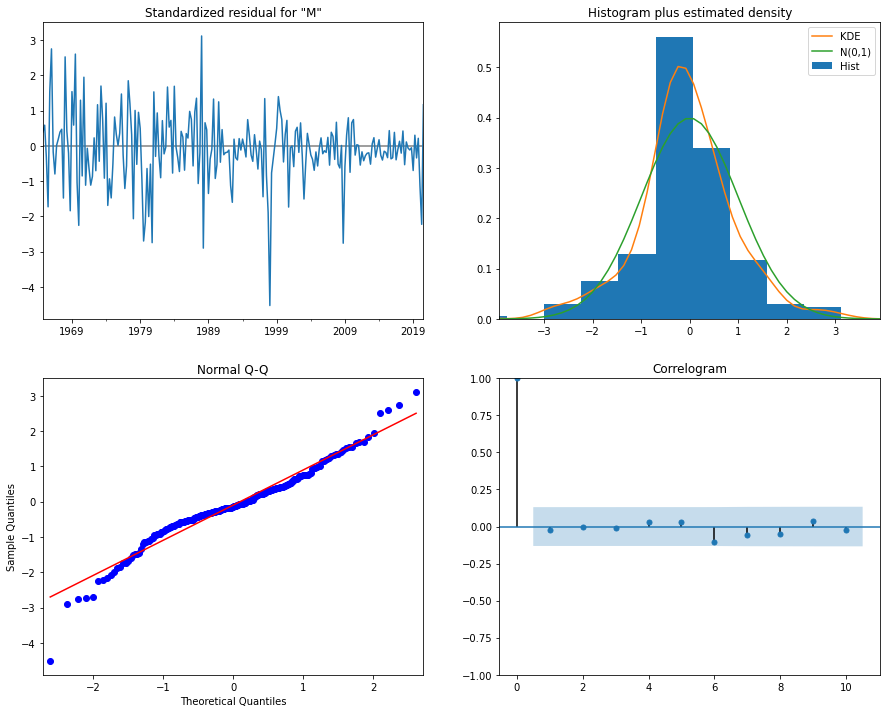

In [23]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Notre principale préoccupation est de nous assurer que les résidus de notre modèle ne sont pas corrélés et normalement distribués avec une moyenne nulle.

Dans ce cas, nos diagnostics de modèle suggèrent que les résidus du modèle sont normalement distribués en fonction des éléments suivants:

## Standardized residual & correlogram

Le graphique en haut à gauche n'affiche pas de saisonnalité évidente. Ceci est confirmé par le correlogram en bas à droite, il montre que la plupart des données ne sont pas corrélées.  

## Histogramme

Dans le graphique en haut à droite, nous voyons que la ligne KDE orange suit a peu près la ligne N(0,1). 
Grâce à ce graphe on peut voir qu'en général les résidus sont normalement distribués sauf pour certains points.

## Graphique QQ normal

Ce graphique montre si les résidus sont normalement distribués. Un bon graphique QQ normal a tous les résidus se trouvant sur ou près de la ligne rouge, ce qui est à peu près le cas de notre graphique.

Certains points qui se situent loin de la ligne rouge. Ceci indique que les erreurs ne sont pas normalement distribuées, en fait notre modèle souffre de «queues lourdes».

Nous sommes donc plus susceptibles de voir des valeurs extrêmes que prévu si les données étaient réellement distribuées normalement.



On fait des prédiction à partir du Q3 de 1990.

In [24]:
pred = results.get_prediction(start=pd.to_datetime('1990-09-01'), dynamic=False)
pred_ci = pred.conf_int()

On trace le graphique en superposant la courbe des moyennes mobiles et la courbe de prédiction.

La partie en gris représente l'intervalle de confiance.

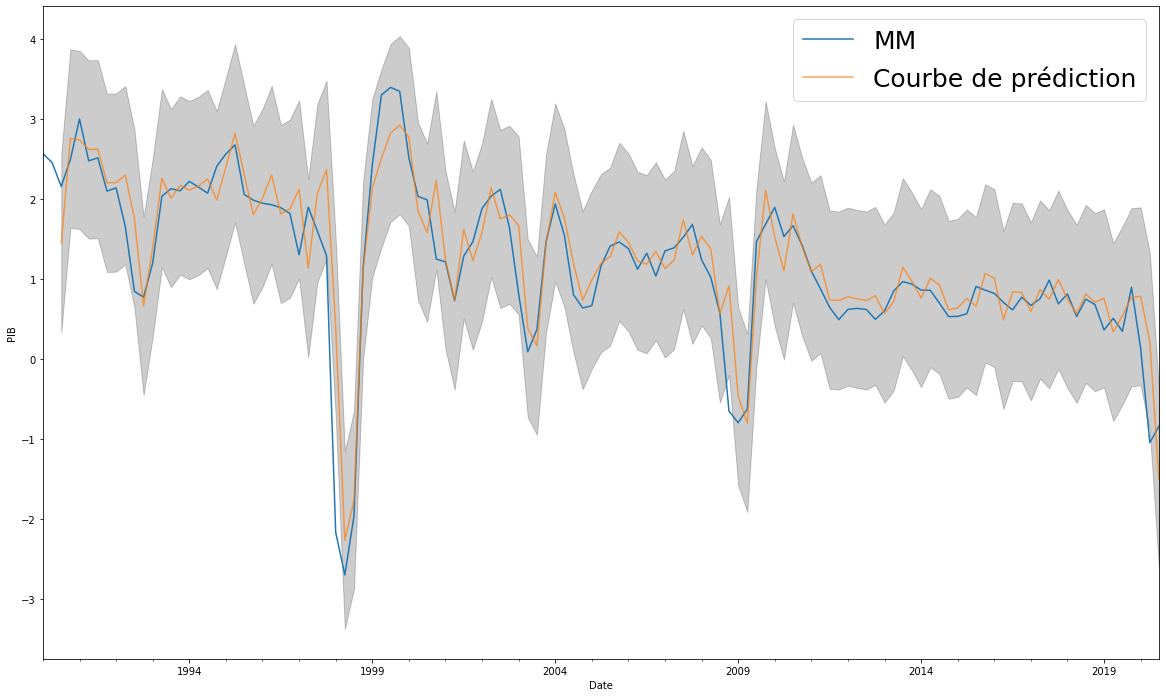

In [25]:
ax = korNL['1990':].plot(label='observed',figsize=(20,12))
pred.predicted_mean.plot(ax=ax, label='Courbe de prédiction', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('PIB')

plt.legend(prop={"size":25})

plt.show()

## Comparaison avec ARIMA(1,1,1)x(0,1,1,4)4 

On compare notre modèle avec d'autres paramètres en affichant les mêmes graphiques que précédemment. 

In [26]:
mod1 = sm.tsa.statespace.SARIMAX(korNL,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 4),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_1 = mod1.fit()

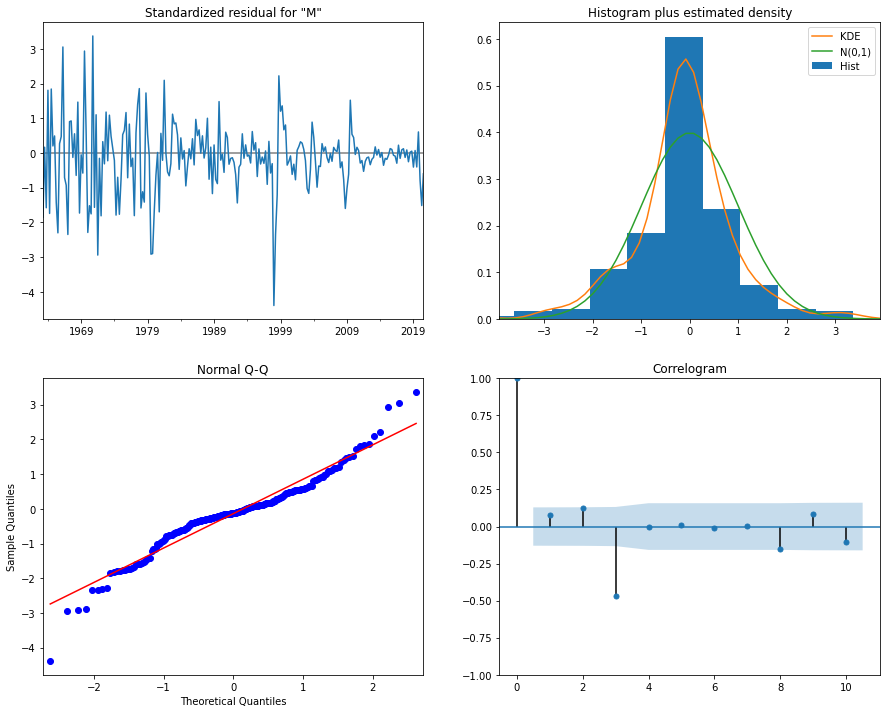

In [27]:
results_1.plot_diagnostics(figsize=(15, 12))
plt.show()

In [28]:
pred_1 = results_1.get_prediction(start=pd.to_datetime('1990-09-01'), dynamic=False)
pred_ci_1 = pred_1.conf_int()

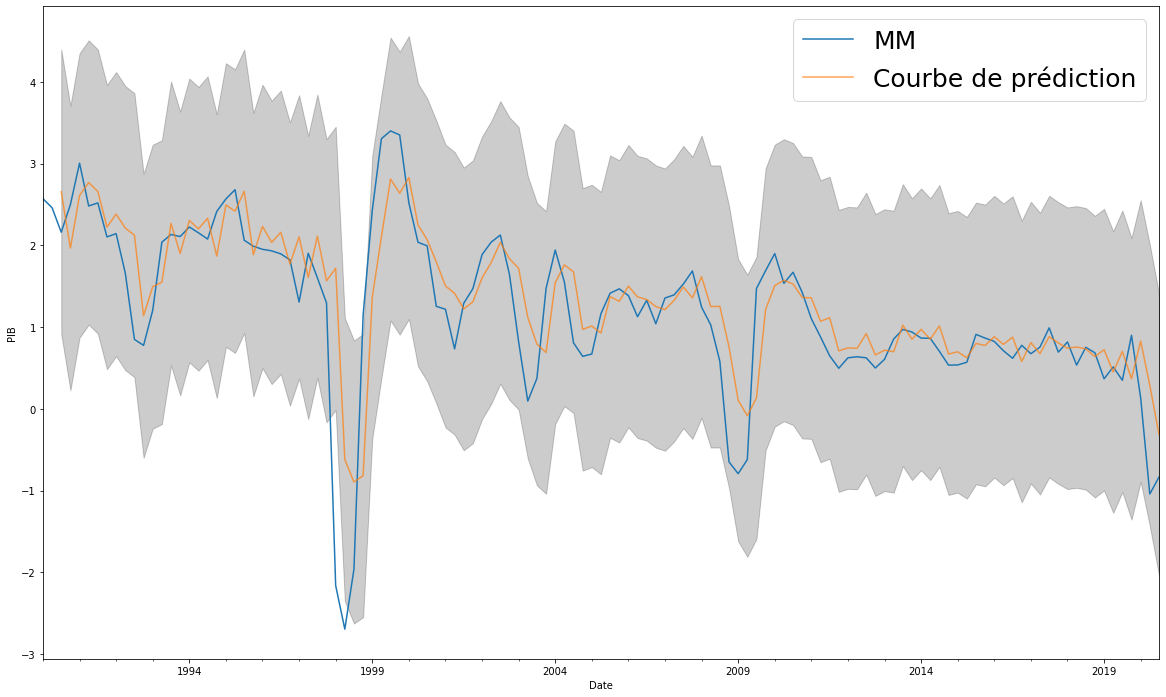

In [29]:
ax = korNL['1990':].plot(label='observed',figsize=(20,12))
pred_1.predicted_mean.plot(ax=ax, label='Courbe de prédiction', alpha=.7)

ax.fill_between(pred_ci_1.index,
                pred_ci_1.iloc[:, 0],
                pred_ci_1.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('PIB')

plt.legend(prop={"size":25})

plt.show()

On peut voir que le modèle avec les paramètres ARIMA(1,1,1)x(0,1,1,4)4 est moins précis que celui (3,1,3)x(3,0,3,4)4, on peut notamment remarquer que la courbe de prédiction en jaune suit moins bien la courbe des évènements passés.

C'est pourquoi, on conserve les paramètres ARIMA(3,1,3)x(3,0,3,4)4 comme modèle pour faire la prédiction future.

In [30]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=20)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

Le graphique ci-dessous représente la prédiction pour les 20 prochains quartiles après Q3 de 2020.

La partie en gris représente l'intervalle de confiance.

On peut voir que notre modèle prédit que le PIB va réaugmenter dans les prochains mois.

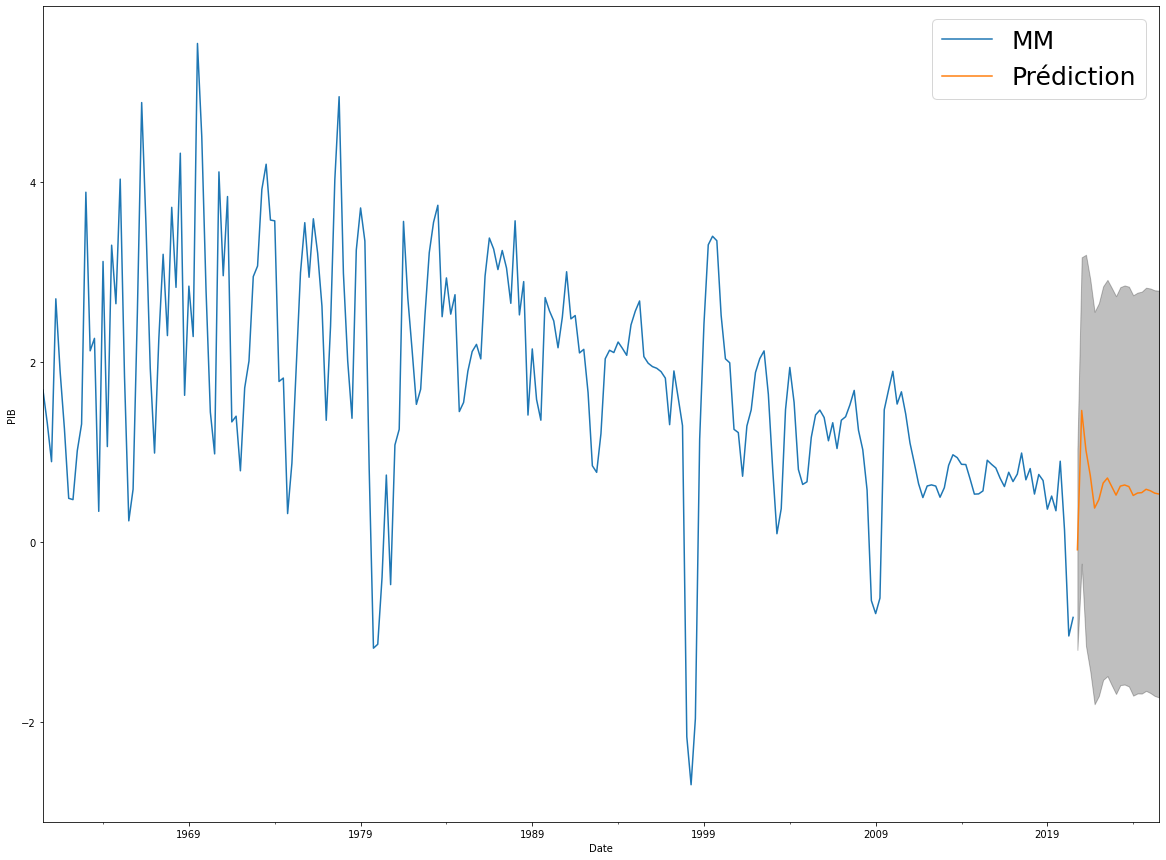

In [31]:
ax = korNL.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Prédiction')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('PIB')

plt.legend(prop={"size":25})
plt.show()

# Modèle de régression linéaire

Un modèle de régression linéaire est un modèle qui cherche  à établir une relation linéaire entre une ou plusieurs variables.

In [32]:
korAC

,TIME,MM
1,1960-09-01,1.692221
2,1960-12-01,1.326914
3,1961-03-01,0.895221
4,1961-06-01,2.704550
5,1961-09-01,1.897368
...,...,...
237,2019-09-01,0.349968
238,2019-12-01,0.900409
239,2020-03-01,0.135128
240,2020-06-01,-1.041308


On modifie le type de 'TIME' pour que les valeurs puissent être utilisées dans la régression linéaire.

In [33]:
import datetime as dt
korAC['TIME'] = pd.to_datetime(korAC['TIME'])
korAC['TIME']=korAC['TIME'].map(dt.datetime.toordinal)

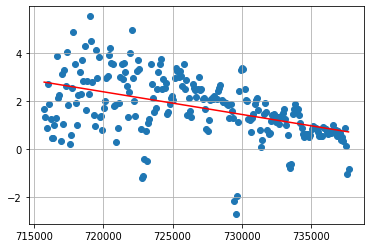

Prediction de 730 000 : 1.4487758886272104
Equation de la dorite :  -9.465099834882102e-05 *x +  70.54400468326655


In [34]:
from scipy import stats


def predict(x):
    return slope * x + intercept


X =  korAC.iloc[0:len(df),0] #selection de la première colonne de notre dataset
Y =  korAC.iloc[0:len(df),1]

axes = plt.axes()
axes.grid()
plt.scatter(X,Y)


slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)

fitLine = predict(X)
plt.plot(X, fitLine, c='r')
plt.show()

print('Prediction de 730 000 :',predict(730000))
print('Equation de la dorite : ',slope ,'*x + ',intercept)


Sur le graphique ci-dessus, on peut voir en rouge la droite qui établi la relation linéaire entre nos points.

En appelant la fonction predict, on peut prevoir lA variation de PIB à une période donnée. Par exemple, ici nous avons fait la prédiction de 730000 ce qui nous donne 1.44, cette valeur est cohérente avec notre droite. 

L'équation de la droite est de la forme : F(x)= slope*x + intercept. Ici nous avons donc comme équation environ -9.46*x+70.5. 

Point à améliorer : notre échelle dess abscisses de vrait être adaptée pour que les dates apparaissent.

# Conclusion

Nous avons fait deux modèles de prédiction, un linéaire avec la régression linéaire et l'autre non linéaire avec le modèle ARIMA. 

Selon nous, le modèle ARIMA est plus adapté pour faire des prédictions. En effet, on a pu voir que les prédictions faites sur les années passées sont assez cohérentes avec ce qu'il s'est réellement passé.